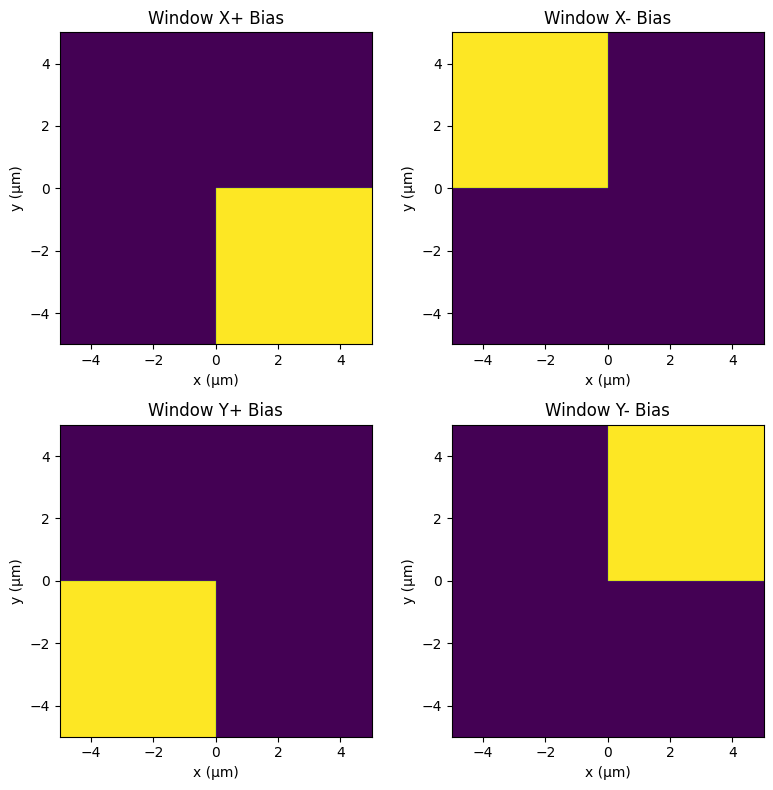

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 设定网格
grid_size = 512   # 采样点数，越高越细
L = 10e-6         # 整个目标物理尺寸 10 μm
dx = L / grid_size
x = np.linspace(-L/2, L/2, grid_size)
y = np.linspace(-L/2, L/2, grid_size)
X, Y = np.meshgrid(x, y)

# 初始化四个窗口函数
W_xb = np.zeros_like(X)   # x+b
W_xm = np.zeros_like(X)   # x-b
W_yb = np.zeros_like(X)   # y+b
W_ym = np.zeros_like(X)   # y-b

# 定义四个区域，分别赋值1
# 分成左右、上下各半区域
W_xb[(X > 0) & (Y > 0)] = 1  # 右上
W_xm[(X < 0) & (Y < 0)] = 1  # 左下
W_yb[(X < 0) & (Y > 0)] = 1  # 左上
W_ym[(X > 0) & (Y < 0)] = 1  # 右下

# 画一下四个窗口函数看看
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(W_xb, extent=[-5,5,-5,5])
axs[0, 0].set_title('Window X+ Bias')
axs[0, 1].imshow(W_xm, extent=[-5,5,-5,5])
axs[0, 1].set_title('Window X- Bias')
axs[1, 0].imshow(W_yb, extent=[-5,5,-5,5])
axs[1, 0].set_title('Window Y+ Bias')
axs[1, 1].imshow(W_ym, extent=[-5,5,-5,5])
axs[1, 1].set_title('Window Y- Bias')
for ax in axs.flat:
    ax.set_xlabel('x (μm)')
    ax.set_ylabel('y (μm)')
plt.tight_layout()
plt.show()

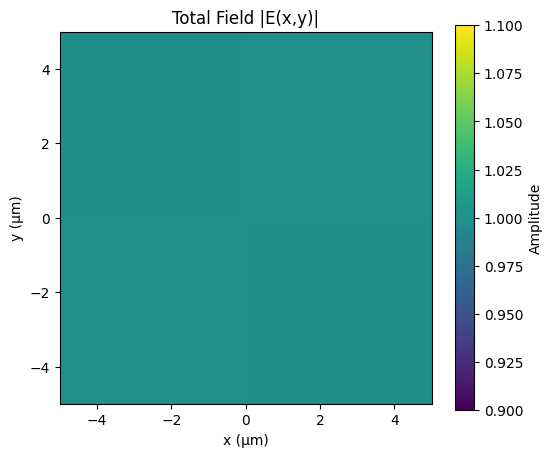

In [11]:
# 简单假设：每个子光栅反射一个不同相位的平面波
E_xb = np.exp(1j * 2*np.pi * np.random.rand()) * np.ones_like(X)
E_xm = np.exp(1j * 2*np.pi * np.random.rand()) * np.ones_like(X)
E_yb = np.exp(1j * 2*np.pi * np.random.rand()) * np.ones_like(X)
E_ym = np.exp(1j * 2*np.pi * np.random.rand()) * np.ones_like(X)

# 组合成总场
E_total = W_xb * E_xb + W_xm * E_xm + W_yb * E_yb + W_ym * E_ym

# 画一下组合后的总场（幅度）
plt.figure(figsize=(6,5))
plt.imshow(np.abs(E_total),extent=[-5,5,-5,5])
plt.title('Total Field |E(x,y)|')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='Amplitude')
plt.show()

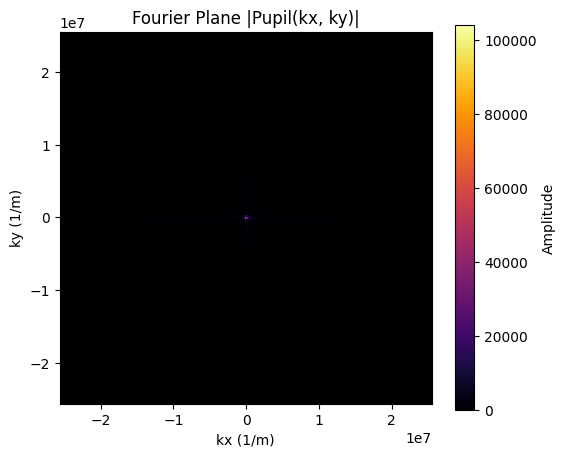

In [3]:
# 先做傅里叶变换
Pupil = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E_total)))

# 傅里叶面上的 k-space 轴（单位可以暂时是归一化单位）
kx = np.fft.fftshift(np.fft.fftfreq(grid_size, d=dx))
ky = np.fft.fftshift(np.fft.fftfreq(grid_size, d=dx))
KX, KY = np.meshgrid(kx, ky)

# 画出傅里叶平面的幅度（通常幅度平方代表能量分布）
plt.figure(figsize=(6,5))
plt.imshow(np.abs(Pupil), extent=[kx.min(), kx.max(), ky.min(), ky.max()], cmap='inferno')
plt.title('Fourier Plane |Pupil(kx, ky)|')
plt.xlabel('kx (1/m)')
plt.ylabel('ky (1/m)')
plt.colorbar(label='Amplitude')
plt.show()

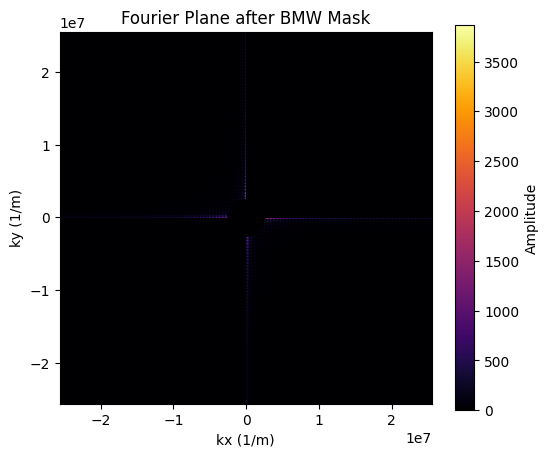

In [4]:
# 设定遮挡半径（中心0级遮挡）
center_block_radius = 0.1 * np.max(np.abs(kx))  # 屏蔽中心10%范围，可调整

# 构建遮挡掩模
BMW_mask = np.zeros_like(Pupil, dtype=bool)

# 条件1：保留右上角 (kx>0, ky>0) 或左下角 (kx<0, ky<0)
BMW_mask[((KX > 0) & (KY > 0)) | ((KX < 0) & (KY < 0))] = True

# 条件2：屏蔽中心0级附近
center = np.sqrt(KX**2 + KY**2) < center_block_radius
BMW_mask[center] = False

# 应用BMW掩模
Pupil_masked = Pupil * BMW_mask

# 画出遮挡后的傅里叶平面
plt.figure(figsize=(6,5))
plt.imshow(np.abs(Pupil_masked), extent=[kx.min(), kx.max(), ky.min(), ky.max()], cmap='inferno')
plt.title('Fourier Plane after BMW Mask')
plt.xlabel('kx (1/m)')
plt.ylabel('ky (1/m)')
plt.colorbar(label='Amplitude')
plt.show()

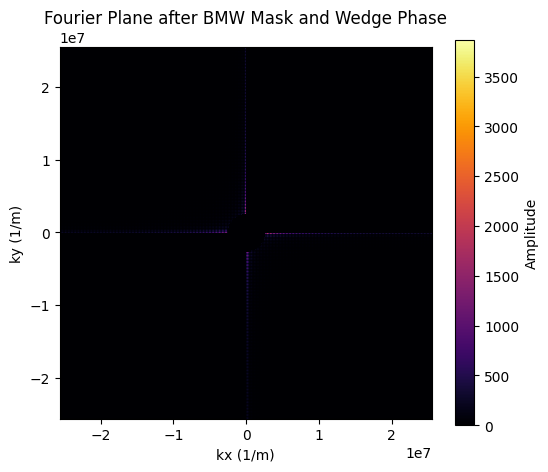

In [5]:
# 楔形相位参数，单位是米（可以调整大小，控制推开程度）
ax = 50e-6   # 5微米推开
ay = 50e-6

# 生成整体Wedge相位矩阵
Wedge_phase = np.zeros_like(Pupil, dtype=np.complex128)

# 条件：对右上角 (kx>0, ky>0)
mask_ru = (KX > 0) & (KY > 0)
Wedge_phase[mask_ru] = np.exp(1j * 2 * np.pi * (ax * KX[mask_ru] + ay * KY[mask_ru]))

# 条件：对左下角 (kx<0, ky<0)
mask_ld = (KX < 0) & (KY < 0)
Wedge_phase[mask_ld] = np.exp(1j * 2 * np.pi * (-ax * KX[mask_ld] - ay * KY[mask_ld]))

# 应用Wedge相位
Pupil_wedged = Pupil_masked * Wedge_phase

# 画一下施加完楔形相位后的傅里叶平面
plt.figure(figsize=(6,5))
plt.imshow(np.abs(Pupil_wedged), extent=[kx.min(), kx.max(), ky.min(), ky.max()], cmap='inferno')
plt.title('Fourier Plane after BMW Mask and Wedge Phase')
plt.xlabel('kx (1/m)')
plt.ylabel('ky (1/m)')
plt.colorbar(label='Amplitude')
plt.show()

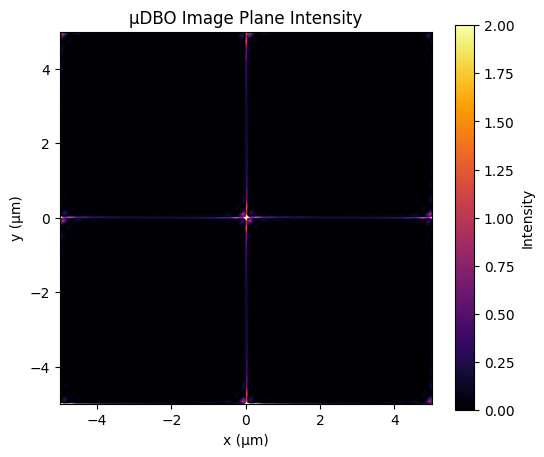

In [8]:
# 反傅里叶变换，得到成像平面
Image_plane = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(Pupil_wedged)))

# 画成像结果
plt.figure(figsize=(6,5))
plt.imshow(np.abs(Image_plane)**2, extent=[-5,5,-5,5], cmap='inferno',
           vmin=0, vmax=2)
plt.title('μDBO Image Plane Intensity')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='Intensity')
plt.show()